<a href="https://colab.research.google.com/github/KimaniKibuthu/pneumonia-classification/blob/main/Pneumonia_Image_Classification_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Classification

The dataset contains x ray images of lungs with pneumonia and those without. Goal is to create a model that accurately predicts that someone has pneumonia or not.



# Import the necessary libraries

In [1]:
# General libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3

In [2]:
# Variables

TARGET_SIZE = 224
TEST_SIZE = 0.5
BATCH_SIZE = 64
RANDOM_STATE = 42
EPOCHS = 5
LR = 0.0001

# Load data

In [3]:
# Load credentials
def credentials(name, token_id):
   # Setup the username and ID
  os.environ["KAGGLE_USERNAME"] = name
  os.environ["KAGGLE_KEY"] = token_id

  print('Done!')

In [4]:
# Download data
credentials('kimanikibuthu', 'f85c0bb5d43058fddcce7902e1325677')

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Done!
100% 2.29G/2.29G [00:30<00:00, 42.0MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.8MB/s]


In [5]:
# Unzip the data'
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [6]:
# Define paths
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'
validation_path = '/content/chest_xray/val'

CLASSES = ['NORMAL', 'PNEUMONIA']

# Data Preprocessing

**General Exploration**

In [7]:
# Check for the number of images
for category in CLASSES:
  print(f'In the train data, {category} has {len(os.listdir(os.path.join(train_path, category)))} images')
  print(f'In the validation data, {category} has {len(os.listdir(os.path.join(validation_path, category)))} images')
  print(f'In the test data, {category} has {len(os.listdir(os.path.join(test_path, category)))} images')

In the train data, NORMAL has 1341 images
In the validation data, NORMAL has 8 images
In the test data, NORMAL has 234 images
In the train data, PNEUMONIA has 3875 images
In the validation data, PNEUMONIA has 8 images
In the test data, PNEUMONIA has 390 images


The training dataset is pretty imbalanced, with normal lung images making up **25%** of the dataset and lungs with pneumonia making up **75%**.

In [8]:
# View the data
def show_images(base_path, class_name):
    # Get images 
    print(f'{class_name}')
    path = os.path.join(base_path, class_name)
    images = os.listdir(path)
    # Extract 16 random images from it
    random_images = [np.random.choice(images) for i in range(8)]

    # Adjust the size of your images
    plt.figure(figsize=(16,12))

    # Iterate and plot random images
  
    for i in range(8):
        plt.subplot(2,4,i+1)
        img = plt.imread(os.path.join(path, random_images[i]))
        
        try:
          plt.imshow(img, cmap='gray')
          plt.axis('off')
        except FileNotFoundError:
          pass

    # Adjust subplot parameters to give specified padding
    plt.tight_layout() 

NORMAL


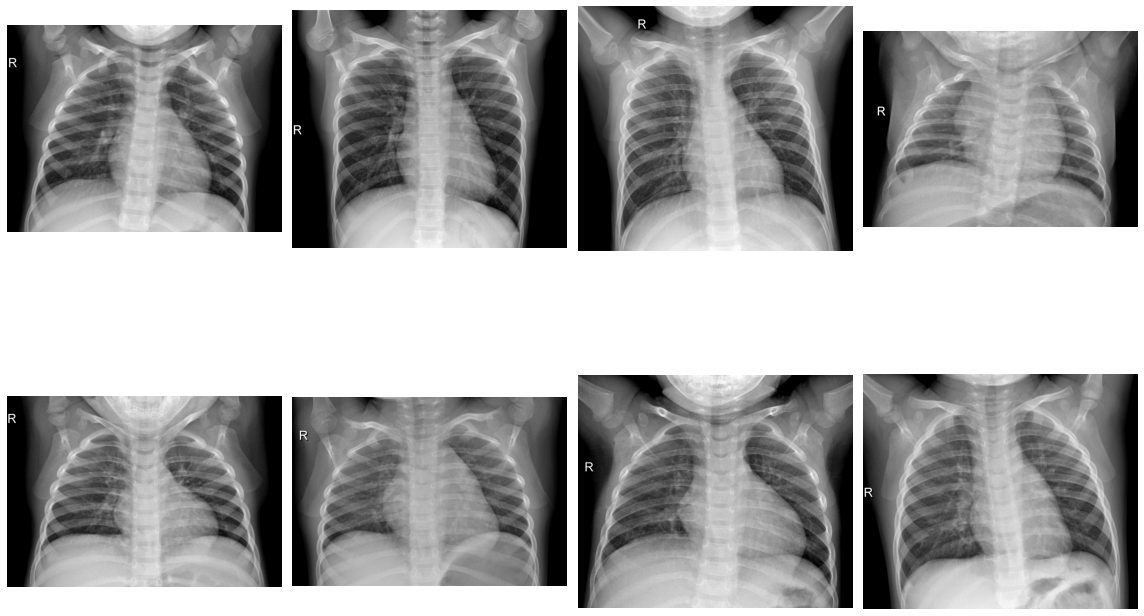

In [9]:
# Train images (NORMAL)
show_images(train_path, 'NORMAL')

PNEUMONIA


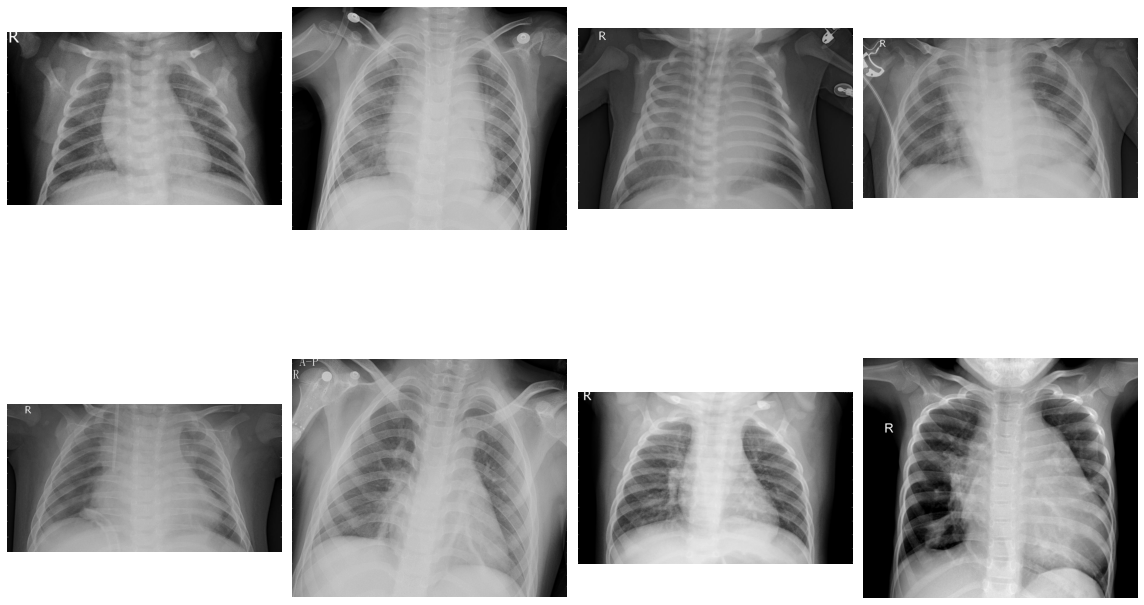

In [10]:
# Train images (PNEUMONIA)
show_images(train_path, 'PNEUMONIA')

NORMAL


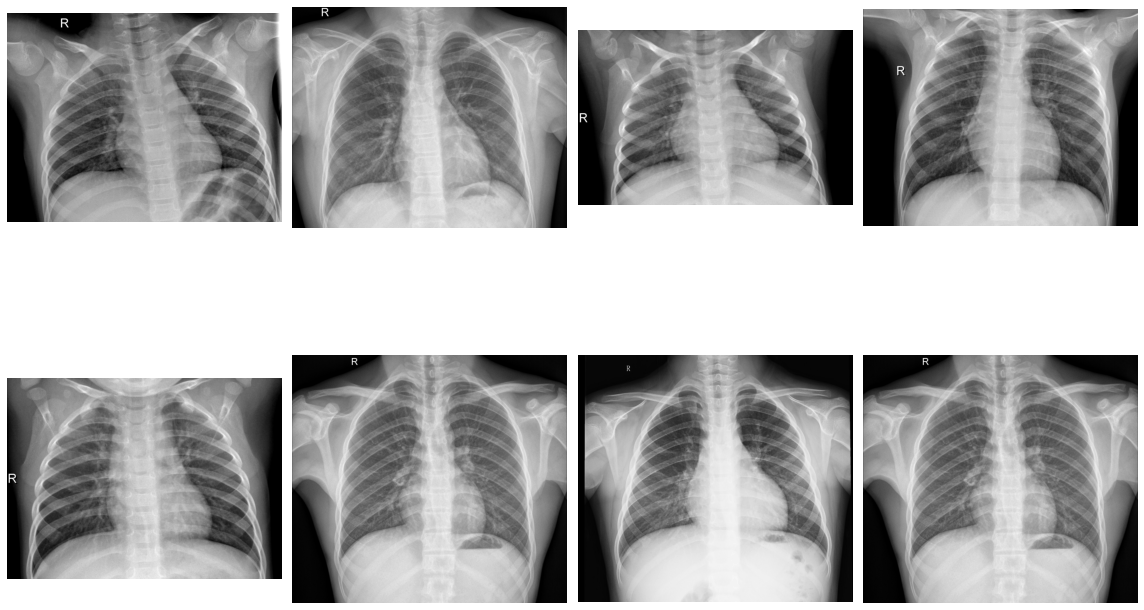

In [11]:
# Test images (NORMAL)
show_images(test_path, 'NORMAL')

PNEUMONIA


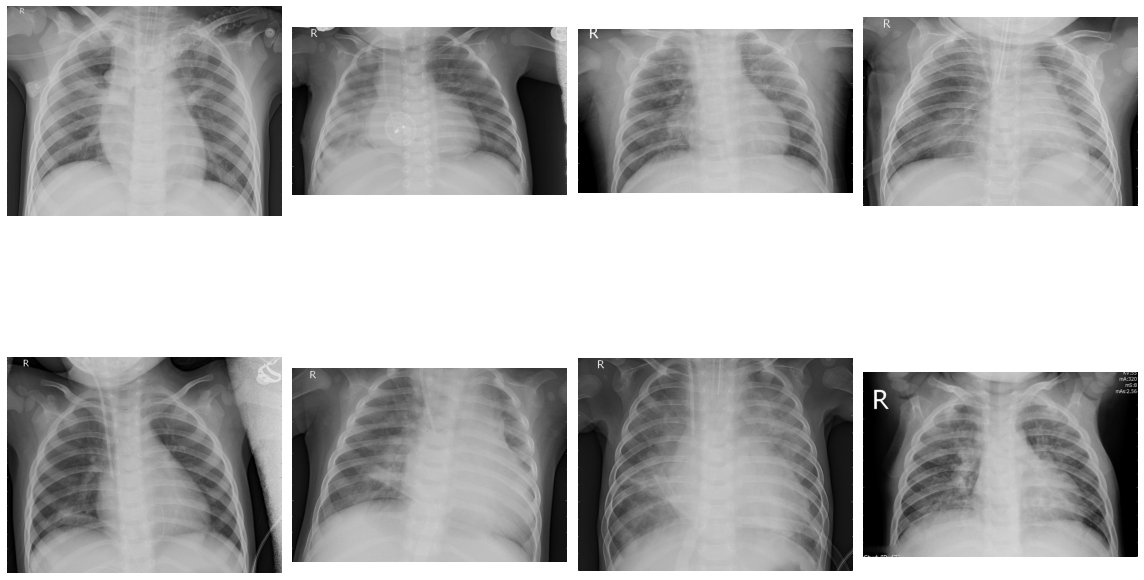

In [12]:
# Test images (PNEUMONIA)
show_images(test_path, 'PNEUMONIA')

NORMAL


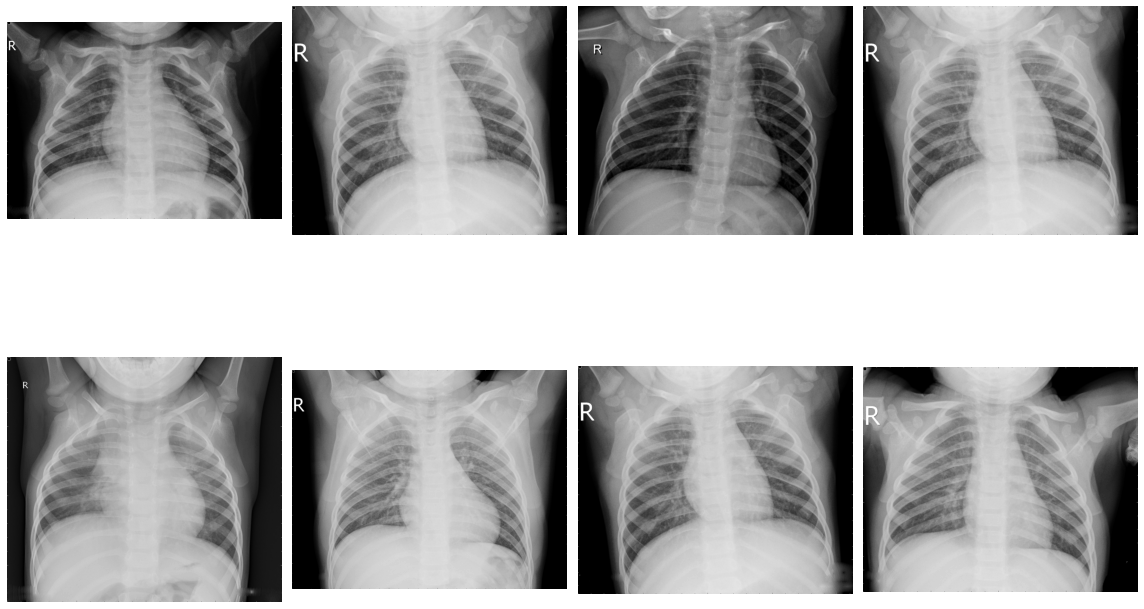

In [13]:
# Val images (NORMAL)
show_images(validation_path, 'NORMAL')

PNEUMONIA


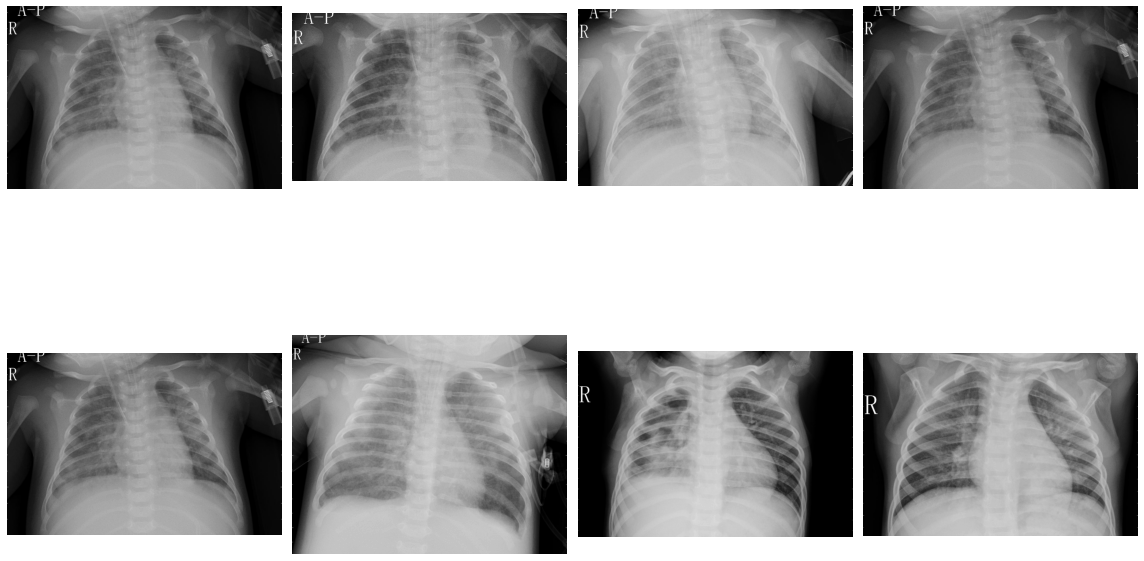

In [14]:
# Val images (PNEUMONIA)
show_images(validation_path, 'PNEUMONIA')

**Preprocessing and Creation of Generators**

With the data generators, the thing we could do is apply the preprocessing function.

In [15]:
# Create Generator objects
train_generator = ImageDataGenerator(
    
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input 
)

val_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input 
)

test_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input 
)

In [54]:
# Create flows
train_flow = train_generator.flow_from_directory(train_path,
                                                 target_size=(TARGET_SIZE, TARGET_SIZE),
                                                 class_mode='binary',
                                                 batch_size = BATCH_SIZE)


val_flow = val_generator.flow_from_directory(validation_path,
                                                 target_size=(TARGET_SIZE, TARGET_SIZE),
                                                 class_mode='binary',
                                                 batch_size = 2,
                                             
                                             
                                             shuffle=False)

test_flow = test_generator.flow_from_directory(test_path,
                                                 target_size=(TARGET_SIZE, TARGET_SIZE),
                                                 class_mode='binary',
                                                 batch_size = BATCH_SIZE)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
test_flow.samples

624

# Modelling

In [68]:
NUM_CLASSES = 2

bias = np.log([1341/3875])

In [87]:
def create_model():
  global NUM_CLASSES
  # Build model
  inception = InceptionV3(include_top=False, 
                          input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
                          weights='imagenet')
  
  for layer in inception.layers:
    layer.trainable = False

  model = Sequential([
                      inception,
                      GlobalAveragePooling2D(),
                      #Flatten(),
                      Dense(256, activation = 'relu', 
                           bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, 
                                                                       l2=0.001)),
                      Dropout(0.5),
                      Dense(32, activation = 'relu',
                            bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01,
                                                                        l2=0.001)),
                      Dropout(0.5),
                      Dense(1, activation = 'sigmoid',
                            bias_initializer= tf.keras.initializers.Constant(bias))
  ])

  # Instantiate learning rate and optimizer
  loss = tf.keras.losses.BinaryCrossentropy(from_logits = False,
                                                   label_smoothing=0.01,
                                                   name='binary_crossentropy' )

  adam = tf.keras.optimizers.Adam(LR)

  auc = tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation', name=None, dtype=None,
    thresholds=None, multi_label=False, num_labels=None, label_weights=None,
    from_logits=False)

  # Compile model
  model.compile(loss = loss,
                optimizer = adam,
                metrics = ['categorical_accuracy', auc])
  
  return model
  

In [89]:
def model_fitter(model):

  # instantiate callbacks
  
  early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',
                                                 patience=5)

  # reduce learning rate
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_categorical_accuracy',
                                  factor = 0.1,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)

  callbacks = [early_stopper, reduce_lr]

  # Train model
  history = model.fit(train_flow,
                    epochs=EPOCHS,
                    steps_per_epoch=int(np.ceil(train_flow.samples)/BATCH_SIZE),
                    callbacks=callbacks,
                    validation_data=val_flow,
                    validation_steps=int(np.ceil(val_flow.samples)/2)
                    )
  
  return history, model

In [90]:
# Create model
model = create_model()

In [91]:
# Train model
history, model = model_fitter(model)

Epoch 1/5
81/81 [==============================] - 58s 668ms/step - loss: 0.6265 - categorical_accuracy: 1.0000 - auc_4: 0.6796 - val_loss: 0.5714 - val_categorical_accuracy: 1.0000 - val_auc_4: 0.8828
Epoch 2/5
81/81 [==============================] - 53s 649ms/step - loss: 0.3598 - categorical_accuracy: 1.0000 - auc_4: 0.8973 - val_loss: 0.4645 - val_categorical_accuracy: 1.0000 - val_auc_4: 0.9062
Epoch 3/5
81/81 [==============================] - 51s 630ms/step - loss: 0.3021 - categorical_accuracy: 1.0000 - auc_4: 0.9327 - val_loss: 0.4601 - val_categorical_accuracy: 1.0000 - val_auc_4: 0.9062

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/5
81/81 [==============================] - 51s 633ms/step - loss: 0.2831 - categorical_accuracy: 1.0000 - auc_4: 0.9423 - val_loss: 0.4699 - val_categorical_accuracy: 1.0000 - val_auc_4: 0.9062
Epoch 5/5
81/81 [==============================] - 51s 632ms/step - loss: 0.2758 - categorical_accuracy: 1.0000

In [92]:
 def plot_interactive_figures(model_history, metric, all=True, test_data=True):
    """
    Plot the performance metrics of the model


    :param model_history: history

    The model history obtained from model.fit()

    :param metric: str
    The performance metric you want to use.**loss**, **categorical_accuracy**

    :param all: bool
    default=True. If true, overrides metric and plots figures of categorical_accuracy and loss.
    If false, plots the metric defined.

    :param test_data: bool
    default = True.
    If you have used validation data or not

    :return:
    Performance of the model
    """

    import plotly.graph_objects as go

    if all:
        if test_data:
            acc = model_history.history['categorical_accuracy']
            val_acc = model_history.history['val_categorical_accuracy']

            loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']
            epochs = list(range(len(acc)+1))
            # Plots
            ax = go.Figure()
            ax.add_trace(go.Scatter(x=epochs, y=val_acc, name='Validation categorical_accuracy',
                                    line=dict(color='yellow', width=4)))
            ax.add_trace(go.Scatter(x=epochs, y=acc, name='Train categorical_accuracy',
                                    line=dict(color='blue', width=4)))
            ax.update_layout(title='Train and Validation categorical_accuracy plots',
                             xaxis_title='Epochs',
                             yaxis_title='categorical_accuracy')
            ax.show()

            bx = go.Figure()
            bx.add_trace(go.Scatter(x=epochs, y=val_loss, name='Validation Loss',
                                    line=dict(color='yellow', width=4)))
            bx.add_trace(go.Scatter(x=epochs, y=loss, name='Train Loss',
                                    line=dict(color='blue', width=4)))
            bx.update_layout(title='Train and Validation Loss plots',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            bx.show()

        if not test_data:
            acc = model_history.history['categorical_accuracy']
            loss = model_history.history['loss']
            epochs = list(range(len(acc)+1))

            cx = go.Figure()
            cx.add_trace(go.Scatter(x=epochs, y=acc, name='categorical_accuracy',
                                    line=dict(color='blue', width=4)))
            cx.update_layout(title='categorical_accuracy plot',
                             xaxis_title='Epochs',
                             yaxis_title='categorical_accuracy')
            cx.show()

            dx = go.Figure()
            dx.add_trace(go.Scatter(x=epochs, y=loss, name='Loss',
                                    line=dict(color='yellow', width=4)))
            dx.update_layout(title='Loss plot',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            dx.show()

    if not all:
        if test_data:
            value_train = model_history.history[metric]
            value_test = model_history.history['val_{}'.format(metric)]
            epochs = list(range(len(value_train)+1))

            ex = go.Figure()
            ex.add_trace(go.Scatter(x=epochs, y=value_test, name='Validation {}'.format(metric),
                                    line=dict(color='yellow', width=4)))
            ex.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            ex.update_layout(title='Train and Validation {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            ex.show()

        if not test_data:
            value_train = model_history.history[metric]
            epochs = list(range(len(value_train)+1))

            fx = go.Figure()
            fx.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            fx.update_layout(title='Train {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            fx.show()


In [93]:
plot_interactive_figures(history, 'categorical_accuracy')

In [63]:
# Save model
model.save('model1.h5')

In [81]:
model.save('model2.h5')

In [94]:
predictions = model.predict(val_flow)

In [95]:
predictions

array([[0.3963558 ],
       [0.18032688],
       [0.576328  ],
       [0.6276779 ],
       [0.257194  ],
       [0.91462845],
       [0.67017317],
       [0.1511283 ],
       [0.9966184 ],
       [0.99445504],
       [0.8895567 ],
       [0.995771  ],
       [0.98067355],
       [0.99634886],
       [0.8933979 ],
       [0.52989256]], dtype=float32)

In [96]:
preds = np.int0(np.around(predictions))

In [97]:
preds_true = np.reshape(val_flow.classes, (16,1))

In [59]:
# import metrics
from sklearn.metrics import classification_report, roc_auc_score

In [98]:
# Verify
print(f'The roc score is {roc_auc_score(preds_true, preds)}')
print(classification_report(preds_true, preds))

The roc score is 0.75
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16

